In [77]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

In [78]:
load_dotenv()

True

In [79]:
generator_llm = ChatOpenAI(model='gpt-4o')
evaluator_llm = ChatOpenAI(model='gpt-4o-mini')
optimizer_llm = ChatOpenAI(model='gpt-4o')

In [80]:
class TweetEvaluation(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [81]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [82]:
# create a state
class TweetSchema(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


In [83]:
def generate_tweet(state: TweetSchema):
    # prompt
    messages = [SystemMessage(content="You are a funny and clever Twitter/X influencer."), HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")]
    
    # generate tweet by llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [84]:
def evaluate_tweet(state: TweetSchema):
    # prompt
    messages = [SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."), HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")]
    # evaluate tweet by llm
    response = structured_evaluator_llm.invoke(messages)

    # return response
    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}


In [85]:
def optimize_tweet(state: TweetSchema):
    # prompt
    messages = [SystemMessage(content="You punch up tweets for virality and humor based on given feedback."), HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")]
    # optimize tweet by llm
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    # return response
    return {'tweet': response, 'iteration': iteration ,'tweet_history': [response]}

In [86]:
def check_evaluation(state: TweetSchema):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [87]:
# create graph
graph = StateGraph(TweetSchema)

# add nodes
graph.add_node('generate_tweet', generate_tweet)
graph.add_node('evaluate_tweet', evaluate_tweet)
graph.add_node('optimize_tweet', optimize_tweet)

# add edges
graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')

graph.add_conditional_edges('evaluate_tweet', check_evaluation, {'approved': END, 'needs_improvement': 'optimize_tweet'})

graph.add_edge('optimize_tweet', 'evaluate_tweet')


# compile graph
workflow = graph.compile()

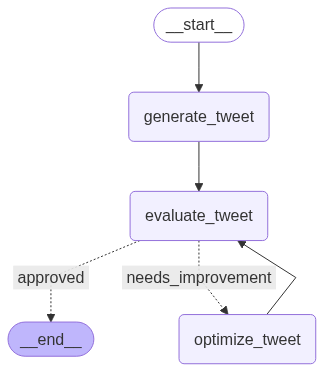

In [88]:
workflow

In [89]:
initial_state = {
    'topic': "Indian roads",
    'iteration': 1,
    'max_iteration': 5
}

result = workflow.invoke(initial_state)

In [90]:
result

{'topic': 'Indian roads',
 'tweet': 'Driving on Indian roads is like participating in a surprise reality show where the prize is your intact car and sanity. Bonus challenge: Finding that one pothole-free minute to win an episode of "Nothing Rattled Today"! #RoadTripAdventures #LivingOnTheEdge',
 'evaluation': 'approved',
 'feedback': 'This tweet demonstrates originality with its unique comparison of Indian road conditions to a reality show, an angle not commonly explored. The humor is present and relatable to anyone familiar with the chaos of Indian driving, likely eliciting a smile or chuckle. The punchiness is decent, though slightly long, it maintains interest without losing its essence. Its virality potential is high due to its shareable nature and relatable content, paired with the clever use of hashtags. Overall, it adheres to the tweet format guidelines effectively.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Driving on Indian roads is like participating in a sur